In [ ]:
import matplotlib.pyplot as plt
import torch
from datasets import load_dataset
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 9 * 9, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

ds = load_dataset("pantelism/cats-vs-dogs", trust_remote_code=True)
split = ds['train'].train_test_split(test_size=0.2, seed=42)
val_test = split['test'].train_test_split(test_size=0.5, seed=42)
test_dataset = val_test['test']

transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

class HFDataset(Dataset):
    def __init__(self, hf_ds, transform=None):
        self.ds = hf_ds
        self.transform = transform
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, idx):
        item = self.ds[idx]
        img = item["image"].convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = int(item["label"])
        return img, label

test_ds = HFDataset(test_dataset, transform)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

model = CNN().to(device)
try:
    model.load_state_dict(torch.load('cat_dog_cnn_model.pth', map_location=device))
except FileNotFoundError:
    exit()

model.eval()

Using device: cpu


CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=10368, out_features=1, bias=True)
  )
)

In [7]:
def fgsm_attack(model, loss_fn, image, label, epsilon):
    image.requires_grad = True
    output = model(image)
    loss = loss_fn(output, label)
    model.zero_grad()
    loss.backward()
    sign_data_grad = image.grad.data.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, -1, 1)
    return perturbed_image

In [9]:
def test_adversarial(model, device, test_loader, epsilon):
    correct = 0
    criterion = nn.BCEWithLogitsLoss()

    for image, label in test_loader:
        image, label = image.to(device), torch.tensor([label]).float().unsqueeze(1).to(device)
        perturbed_image = fgsm_attack(model, criterion, image, label, epsilon)
        output = model(perturbed_image)
        pred = (torch.sigmoid(output) > 0.5).float()
        if pred.item() == label.item():
            correct += 1
    final_acc = correct / float(len(test_loader))
    return final_acc

epsilons = [0.05, 0.1, 0.2]

for eps in epsilons:
    acc = test_adversarial(model, device, test_loader, eps)
    print(f"Epsilon: {eps}\tAdversarial Accuracy = {acc * 100:.2f}%")

Epsilon: 0.05	Adversarial Accuracy = 9.25%
Epsilon: 0.1	Adversarial Accuracy = 0.75%
Epsilon: 0.2	Adversarial Accuracy = 0.25%


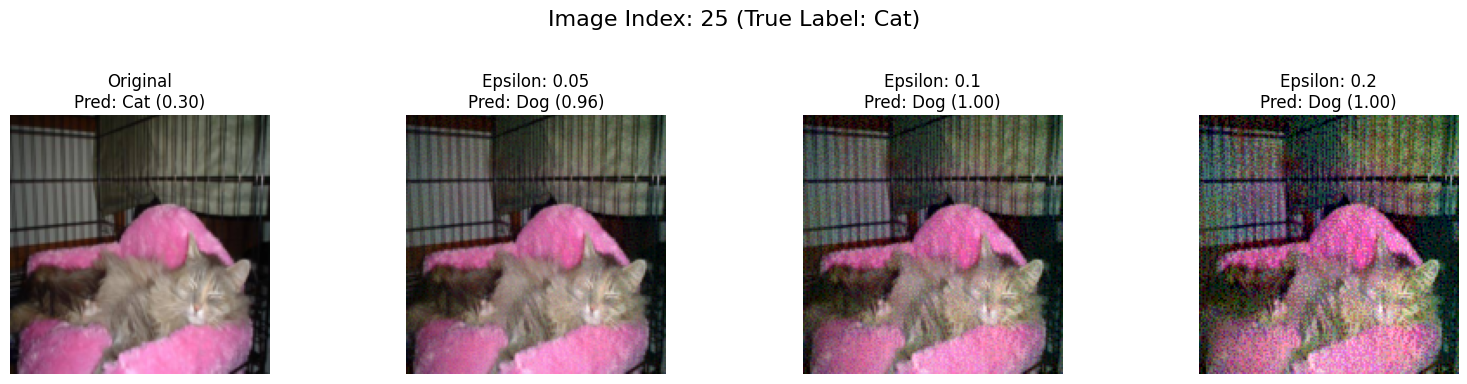

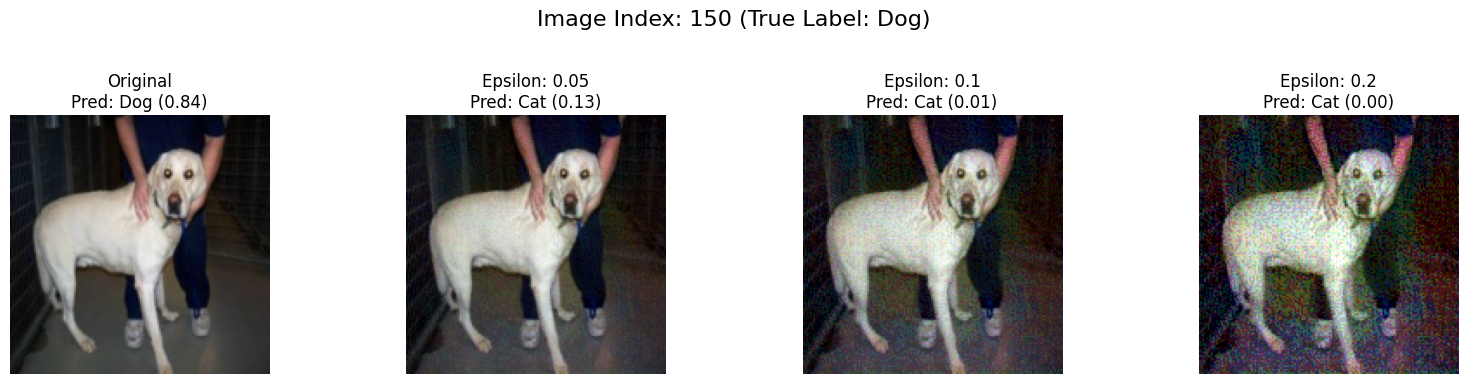

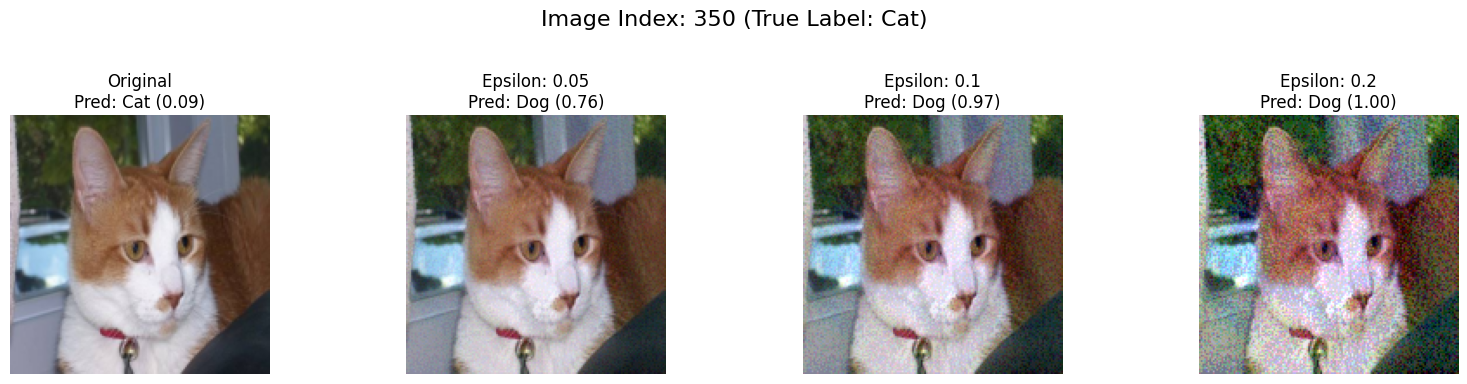

In [10]:
def denormalize(tensor):
    tensor = tensor.clone().detach().cpu().squeeze()
    mean = torch.tensor([0.5, 0.5, 0.5])
    std = torch.tensor([0.5, 0.5, 0.5])
    tensor = tensor * std[:, None, None] + mean[:, None, None]
    return tensor.permute(1, 2, 0)

def visualize_attack(model, device, test_ds, indices_to_show, epsilons):
    class_names = ['Cat', 'Dog']
    criterion = nn.BCEWithLogitsLoss()

    for idx in indices_to_show:
        # original image and label
        image, label = test_ds[idx]
        image = image.unsqueeze(0).to(device)
        true_label_tensor = torch.tensor([label]).float().unsqueeze(1).to(device)

        # original prediction
        with torch.no_grad():
            original_output = model(image)
            original_prob = torch.sigmoid(original_output).item()
            original_pred = (original_prob > 0.5)

        fig, axes = plt.subplots(1, len(epsilons) + 1, figsize=(16, 4))
        fig.suptitle(f'Image Index: {idx} (True Label: {class_names[label]})', fontsize=16)

        axes[0].imshow(denormalize(image))
        axes[0].set_title(f"Original\nPred: {class_names[original_pred]} ({original_prob:.2f})")
        axes[0].axis('off')

        for i, epsilon in enumerate(epsilons):
            perturbed_image = fgsm_attack(model, criterion, image, true_label_tensor, epsilon)

            with torch.no_grad():
                adv_output = model(perturbed_image)
                adv_prob = torch.sigmoid(adv_output).item()
                adv_pred = (adv_prob > 0.5)

            axes[i+1].imshow(denormalize(perturbed_image))
            axes[i+1].set_title(f"Epsilon: {epsilon}\nPred: {class_names[adv_pred]} ({adv_prob:.2f})")
            axes[i+1].axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.9])
        plt.show()

indices_to_show = [25, 150, 350]
visualize_attack(model, device, test_ds, indices_to_show, epsilons)

The model might not be good but at least we can fool it easily when it's good; oh my! (pain)